UTILITY FUNCTIONS

In [1]:
import numpy as np
import pandas as pd
import warnings
from typing import List, Tuple, Dict


def split_data(X, y, test_size=0.1, seed=None):
    # shuffle data
    np.random.seed(seed)
    perm = np.random.permutation(X.index)
    X = X.loc[perm]
    y = y.loc[perm]
    
    # split into training and test sets
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        if test_size <= 0 or test_size >= 1:
            raise ValueError("The test size should fall in the range (0,1)")
        n_train = n_samples - round(test_size*n_samples)
    elif isinstance(test_size, int):
        n_train = n_samples - test_size
    else:
        raise ValueError("Improper type \'%s\' for test_size" % type(test_size))

    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, X_test, y_train, y_test

def encode_one_hot(data): # note: pd.get_dummies(df) does the same
    # https://www.kite.com/python/answers/how-to-do-one-hot-encoding-with-numpy-in-python
    one_hot = np.zeros((data.size, data.max()+1))
    rows = np.arange(data.size)
    one_hot[rows, data] = 1
    return one_hot


def confusion_matrix(y_actual, y_pred):
    """ Returns a confusion matrix where the rows are the actual classes, and the columns are the predicted classes"""
    if y_actual.shape != y_pred.shape:
        raise ValueError ("input arrays must have the same shape, {}!={}".format(y_actual.shape, y_pred.shape))
    n = max(max(y_actual), max(y_pred)) + 1
    C = np.zeros((n, n), dtype=int)
    for label_actual in range(n):
        idxs_true = (y_actual == label_actual)
        for label_pred in range(n):
            C[label_actual, label_pred] = sum(y_pred[idxs_true] == label_pred)
    return C

def calc_f1_score(y_actual, y_pred) -> Tuple[float]:
    C = confusion_matrix(y_actual, y_pred)
    if C.shape[0] != 2:
        raise ValueError ("input arrays must only have binary values")
    recall    = C[1][1]/(C[1][0]+C[1][1]) #true positive/actual positive
    precision = C[1][1]/(C[0][1]+C[1][1]) #true positive/predicted positive
    if (recall == 0) or (precision == 0):
        f1 = 0
    else:
        f1 = 2 * recall*precision/(recall + precision) # = 2/((1/recall)+(1/precision))

    print("Recall: {:.4f}".format(recall))
    print("Precision: {:.4f}".format(precision))
    print("F1 Score: {:.4f}".format(f1))


In [2]:
import numpy as np

class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        self.theta = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.theta))

    def predict(self, X, threshold=0.5):
        return (self.predict_prob(X) >= threshold).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
      



In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [4]:
df1=pd.read_csv('/content/bank_loan.csv')
df2=pd.read_csv('/content/bank_loan1.csv')
df1.head()

,ID,Age,Experience,Income,Family,Mortgage,Personal Loan,CD Account,CreditCard
0,1,25,1,49,4,0,0,0,0
1,2,45,19,34,3,0,0,0,0
2,3,39,15,11,1,0,0,0,0
3,4,35,9,100,1,0,0,0,0
4,5,35,8,45,4,0,0,0,1


In [5]:
df2.head()

,ID,ZIP Code,Mortgage,Personal Loan,CD Account,CreditCard
0,1,91107,0,0,0,0
1,2,90089,0,0,0,0
2,3,94720,0,0,0,0
3,4,94112,0,0,0,0
4,5,91330,0,0,0,1


In [6]:
df1.shape,df2.shape

((5000, 9), (5000, 6))

In [7]:
df2.drop(['Mortgage','Personal Loan','CD Account','CreditCard'],axis=1,inplace=True)


In [8]:
df2.drop(['ID'],axis=1,inplace=True)

In [9]:
df = pd.merge(df1, df2, left_index=True,right_index=True)


In [10]:
df.head()

,ID,Age,Experience,Income,Family,Mortgage,Personal Loan,CD Account,CreditCard,ZIP Code
0,1,25,1,49,4,0,0,0,0,91107
1,2,45,19,34,3,0,0,0,0,90089
2,3,39,15,11,1,0,0,0,0,94720
3,4,35,9,100,1,0,0,0,0,94112
4,5,35,8,45,4,0,0,0,1,91330


In [11]:
df.shape

(5000, 10)

In [12]:
df.rename(columns = {'Personal Loan':'Personal_Loan'}, inplace = True)

0    4520
1     480
Name: Personal_Loan, dtype: int64


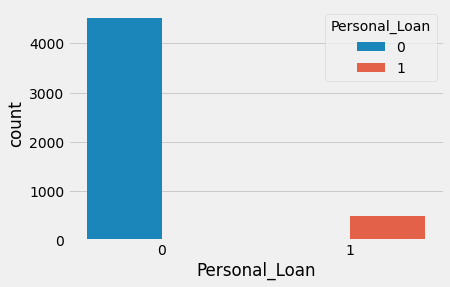

In [13]:
# TARGET DISTRIBUTION PLOT
print(df['Personal_Loan'].value_counts()) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df.Personal_Loan, data=df, hue=df.Personal_Loan)

In [14]:
#Checking for duplication of data
df.duplicated().sum()

0

In [15]:
df.isnull().sum()

ID               0
Age              0
Experience       0
Income           0
Family           0
Mortgage         0
Personal_Loan    0
CD Account       0
CreditCard       0
ZIP Code         0
dtype: int64

In [16]:
# Experience can't have negative values hence replacing it with median
df[df['Experience'] < 0]['Experience'].count()

52

In [17]:
fillneg=df['Experience'].median()
df["Experience"] = df["Experience"].mask(df["Experience"] < 0, fillneg)

In [18]:
df[df['Experience'] < 0]['Experience'].count()

0

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             5000 non-null   int64  
 1   Age            5000 non-null   int64  
 2   Experience     5000 non-null   float64
 3   Income         5000 non-null   int64  
 4   Family         5000 non-null   int64  
 5   Mortgage       5000 non-null   int64  
 6   Personal_Loan  5000 non-null   int64  
 7   CD Account     5000 non-null   int64  
 8   CreditCard     5000 non-null   int64  
 9   ZIP Code       5000 non-null   object 
dtypes: float64(1), int64(8), object(1)
memory usage: 390.8+ KB


<AxesSubplot:>

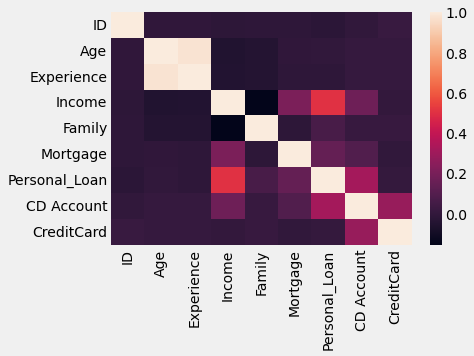

In [20]:
sns.heatmap(df.corr())

In [21]:
# Removing unnessary and highly correlated feature
df=df.drop(['ID','ZIP Code','Mortgage','Age'], axis=1)


In [22]:
# Separating dependent-independent variables
X = df.drop('Personal_Loan',axis=1)
y = df['Personal_Loan']

In [24]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

In [25]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((4000, 5), (4000,), (1000, 5), (1000,))

In [26]:
# Apply SMOTE to oversample the minority class
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [27]:
X_train_res.shape, y_train_res.shape

((7226, 5), (7226,))

In [47]:
  # Define grid search function
def grid_search(X, y, learning_rates, n_iters_values):
        best_acc = 0
        best_lr = None
        best_n_iters = None

        for lr in learning_rates:
            for n_iters in n_iters_values:
              lr = LogisticRegression(lr=0.5, num_iter=5000, fit_intercept=True)
              lr.fit(X, y)
              y_pred = lr.predict(X)
              acc = sum(y_pred == y) / len(y)
              if acc > best_acc:
                best_acc = acc
                best_lr = lr
                best_n_iters = n_iters

            return best_lr, best_n_iters, best_acc

In [48]:
# Define hyperparameter search space
learning_rates = [0.05, 0.5, 5]
n_iters_values = [100, 1000, 10000]

In [49]:

best_lr, best_n_iters, best_acc= grid_search(X, y, learning_rates, n_iters_values)
print("Best score:", best_acc)
print("Best learning_rate:", best_lr)
print("Best n_iters:", best_n_iters)

<ipython-input-2-47161fa7a81b>:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Best score: 0.904
Best learning_rate: <__main__.LogisticRegression object at 0x7f1725dddf40>
Best n_iters: 100


In [32]:
# Instantiate and fit a logistic regression model
lr = LogisticRegression(lr=0.1, num_iter=5000, fit_intercept=True)
lr.fit(X_train_res, y_train_res)

# Evaluate the model on the test set
acc_test = lr.score(X_test, y_test)
acc_train = lr.score(X_train_res, y_train_res)
y_train_pred = lr.predict(X_train_res)
y_pred = lr.predict(X_test)

In [33]:
print("Logistic Regression model")
print("train accuracy: %.2f%%" % (acc_train*100))
print("test accuracy:  %.2f%%" % (acc_test*100))

Logistic Regression model
train accuracy: 80.24%
test accuracy:  67.20%


In [34]:
confusion_matrix(y_test,y_pred)

array([[581, 326],
       [  2,  91]])

In [35]:
calc_f1_score(y_test, y_pred)

Recall: 0.9785
Precision: 0.2182
F1 Score: 0.3569
